In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier 
# Import Packages

In [4]:
def load_activity_map():  # Map of 24 pre-defined activities
    map = {}
    map[0] = 'transient'
    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    map[4] = 'walking'
    map[5] = 'running'
    map[6] = 'cycling'
    map[7] = 'Nordic_walking'
    map[9] = 'watching_TV'
    map[10] = 'computer_work'
    map[11] = 'car driving'
    map[12] = 'ascending_stairs'
    map[13] = 'descending_stairs'
    map[16] = 'vacuum_cleaning'
    map[17] = 'ironing'
    map[18] = 'folding_laundry'
    map[19] = 'house_cleaning'
    map[20] = 'playing_soccer'
    map[24] = 'rope_jumping'
    return map

def generate_three_IMU(name): #vGenerate columns for 3-dimensional data
    x = name +'_x'; y = name +'_y'; z = name +'_z'
    return [x,y,z]

def generate_four_IMU(name): #Generate columns for 4-dimensional data
    x = name +'_x'; y = name +'_y'; z = name +'_z'; w = name +'_w'
    return [x,y,z,w]

def generate_cols_IMU(name): #Generate 5 columns for sensors as described in UCI (hand, chest, ankle)
    temp = name+'_temperature' # temperature
    output = [temp]
    acceleration16 = name+'_3D_acceleration_16' # acceleration (16)
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16) 
    acceleration6 = name+'_3D_acceleration_6'  # acceleration (6)
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    gyroscope = name+'_3D_gyroscope'    # 3D-gyroscope
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    magnometer = name+'_3D_magnetometer'    # 3D-magnometer
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    oreintation = name+'_4D_orientation'    # 4D-oreintation
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output

def load_IMU():  # loading all columns into dataset
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output

def load_subjects(root=r"C:\Users\giant\Downloads\subject"): # Load all nine subjects into one dataframe
    output = pd.DataFrame()
    cols = load_IMU()
    
    for i in range(101,110): # Loops over every dataset in folder
        path = root + str(i) +'.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols 
        subject['id'] = i
        output = output.append(subject, ignore_index=True)
    output.reset_index(drop=True, inplace=True)
    return output

data = load_subjects() # Create dataframe

In [50]:
data

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.95990,-58.143800,1.000000,0.000000,0.000000,0.000000,101
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.89190,-58.525300,1.000000,0.000000,0.000000,0.000000,101
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.41380,-58.399900,1.000000,0.000000,0.000000,0.000000,101
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.76350,-58.395600,1.000000,0.000000,0.000000,0.000000,101
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.38790,-58.269400,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,...,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075,109
2872529,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,...,-0.027006,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018,109
2872530,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,-5.04613,10.35690,4.14405,...,-0.038024,-0.064709,-46.3997,4.22078,0.105504,0.598233,0.033172,0.800095,-0.029416,109
2872531,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,-5.06854,9.75268,3.87359,...,-0.025796,-0.064357,-46.5282,4.48593,0.530240,0.598116,0.033427,0.800180,-0.029207,109


In [57]:
data['activity_id'].value_counts()  # Target Classes

4     238761
17    238690
1     192523
3     189931
7     188107
2     185188
16    175353
6     164600
12    117216
13    104944
5      98199
24     49360
Name: activity_id, dtype: int64

In [58]:
data['id'].value_counts()  # Subject data

105    272442
102    263349
108    262102
106    250096
101    249957
107    232776
104    231421
103    174338
109      6391
Name: id, dtype: int64

In [52]:
def fix(data):  # Cleaning
    data = data.drop(data[data['activity_id']==0].index) # Activity 0 is invalid
    data = data.interpolate() # Linear interpolation, as described in article
    for colName in data.columns: # fill all the NaN values in a coulmn with the mean values of the column
        data[colName] = data[colName].fillna(data[colName].mean())
    activity_mean = data.groupby(['activity_id']).mean().reset_index()
    return data

data = fix(data)

In [55]:
data

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
2928,37.66,1,107.487925,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,-0.027714,0.001752,-61.1081,-36.863600,-58.369600,1.000000,0.000000,0.000000,0.000000,101
2929,37.67,1,107.487925,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,0.000945,0.006007,-60.8916,-36.319700,-58.365600,1.000000,0.000000,0.000000,0.000000,101
2930,37.68,1,107.487925,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,-0.052422,-0.004882,-60.3407,-35.784200,-58.611900,1.000000,0.000000,0.000000,0.000000,101
2931,37.69,1,107.487925,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,-0.018844,0.026950,-60.7646,-37.102800,-57.879900,1.000000,0.000000,0.000000,0.000000,101
2932,37.70,1,100.000000,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,-0.048878,-0.006328,-60.2040,-37.122500,-57.884700,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872015,95.06,24,162.000000,25.125,4.99466,6.01881,5.59830,4.90787,6.05780,5.68357,...,-0.012885,0.005878,-45.7855,-0.831734,-0.170139,0.522929,-0.291612,0.705786,-0.378648,109
2872016,95.07,24,162.000000,25.125,5.02764,5.90369,5.48372,4.89090,5.95209,5.56301,...,0.003629,-0.004235,-46.0331,-0.817288,0.538134,0.522880,-0.291694,0.705895,-0.378450,109
2872017,95.08,24,162.000000,25.125,5.06409,5.71370,5.48491,4.97981,5.87584,5.45738,...,-0.035176,-0.002309,-45.5140,-1.229410,0.540438,0.522625,-0.291978,0.706161,-0.378084,109
2872018,95.09,24,162.000000,25.125,5.13914,5.63724,5.48629,4.97690,5.69448,5.29167,...,-0.036457,-0.007076,-45.9093,-0.565555,0.680109,0.522536,-0.291955,0.706426,-0.377733,109


<BarContainer object of 9 artists>

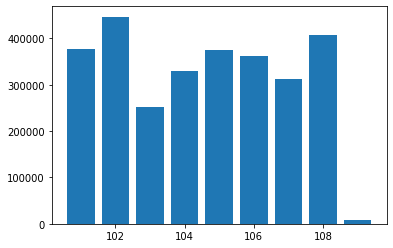

In [9]:
# Bar plot of test subjects
aa=list(data['id'].value_counts().values)
bb=list(data['id'].value_counts().index)
plt.bar(bb,aa)

<BarContainer object of 12 artists>

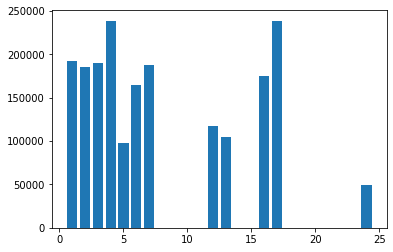

In [11]:
# Bar plot of target variable
a=list(data['activity_id'].value_counts().values)
b=list(data['activity_id'].value_counts().index)
plt.bar(b,a)

In [60]:
# create testing and training sets
t4 = data[data['id'] == 104];t7 = data[data['id'] == 107];test = t4.append(t7)
train = data[data['id'] != 107];train = data[data['id'] != 108]

# drop the subject id column
test = test.drop(["id"], axis=1)
train = train.drop(["id"], axis=1)

# split train and test to X and y (& eliminate timestamp and activity columns)
X_train = train.drop(['activity_id','time_stamp'], axis=1).values
X_test = test.drop(['activity_id','time_stamp'], axis=1).values

In [62]:
 # make data scale to min max beetwin 0 to 1
scaler = MinMaxScaler()
scaler.fit(X_train);scaler.fit(X_test)

X_train = scaler.transform(X_train);X_test = scaler.transform(X_test)
y_train = train['activity_id'].values;y_test = test['activity_id'].values

In [63]:
print('Train shape X :',X_train.shape,' y ', y_train.shape)
print('Test shape X :',X_test.shape,' y ', y_test.shape)

Train shape X : (1680770, 52)  y  (1680770,)
Test shape X : (464197, 52)  y  (464197,)


In [69]:
#create a new random forest classifier
rf = RandomForestClassifier()
#fit model to training data
rfmod=rf.fit(X_train, y_train)

In [70]:
#create a new bagging classifier
bag = BaggingClassifier()
#fit model to training data
bagmod=bag.fit(X_train, y_train)

In [82]:
#create a new boosting classifier
boost = XGBClassifier()
#fit model to training data
boostmod=boost.fit(X_train, y_train)

C:\Users\giant\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:38:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [83]:
#test the three models with the test data and print their accuracy scores
print('boost: {}'.format(boostmod.score(X_test, y_test)))
print('rf: {}'.format(rfmod.score(X_test, y_test)))
print('bag: {}'.format(bagmod.score(X_test, y_test)))

C:\Users\giant\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


boost: 1.0
rf: 1.0
bag: 0.9999698403910409


In [84]:
#create a dictionary of our models
estimators=[('boost', boostmod), ('rf', rfmod), ('bag', bagmod)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

In [85]:
#fit model to training data
ensemble.fit(X_train, y_train)
#test our model on the test data
print(ensemble.score(X_test, y_test))

C:\Users\giant\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:10:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\giant\anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


1.0


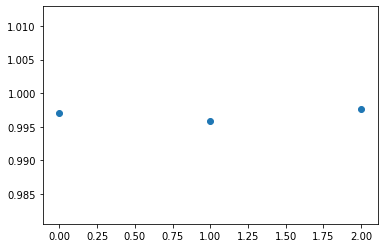

In [19]:
# Ensemble accuracy plot
c=[boostmod.score(X_test, y_test),rfmod.score(X_test, y_test),bagmod.score(X_test, y_test)]
d=[0,1,2]
plt.scatter(d,c)